In [1]:
# import kagglehub
# path = kagglehub.dataset_download("bryanpark/sudoku")
# print("Path to dataset files:", path)

Modelo de leitura básico dos dados.

In [2]:
import numpy as np
import pandas as  pd 

df = pd.read_csv('sudoku.csv', nrows=100000, dtype=str)

quizzes = np.array([list(map(int, list(q))) for q in df['quizzes']], dtype=np.int8)
solutions = np.array([list(map(int, list(s))) for s in df['solutions']], dtype=np.int8)

quizzes = quizzes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))


Como visualizar cada jogo pode ser um pouco difícil devido a como os dados estão estruturados, uma função genérica para deixar a interface do jogo mais palatável pode ajudar na visualização.

Diferente de outros problemas de ML onde o objetivo é tentar entender e interpretar os dados, neste problema o nosso objetivo está em como podemos modelar as regras do jogo. A premissa inicial é tentar estruturar os dados para depois aplica-los em um modelo de classificação multiclasse.  

Antes de mais nada, note que temos dois tensores, `quizzes` e `solutions` ambas com 1 milhão de matrizes $9 \times 9$. Cada jogo de sudoku está contido na $i$ posição da matriz `quizzes[i]`. Para o primeiro jogo ($i=0$) foi usado o $0$ para representar uma posição vazia. A seguir está o exemplo de como o tensor `quizzes` representa um jogo e em seguida uma representação mais "amigável" usando a função acima `sudoku_interface()`.  

In [3]:
print(f"Shape quizzes: {quizzes.shape}")
print(f"Shape solutions: {solutions.shape}") 

print()

print(quizzes[0], "\n")

Shape quizzes: (100000, 9, 9)
Shape solutions: (100000, 9, 9)

[[0 0 4 3 0 0 2 0 9]
 [0 0 5 0 0 9 0 0 1]
 [0 7 0 0 6 0 0 4 3]
 [0 0 6 0 0 2 0 8 7]
 [1 9 0 0 0 7 4 0 0]
 [0 5 0 0 8 3 0 0 0]
 [6 0 0 0 0 0 1 0 5]
 [0 0 3 5 0 8 6 9 0]
 [0 4 2 9 1 0 3 0 0]] 



A primeira coisa a se fazer em problemas de ML é separar o dataset em dois conjuntos: 
* Um para treinamento do classificador `train_set`.
* Outro para o teste do classificador `test_set`.

A distribuição clássica (e que eu vou usar) é de 80/20. 

In [4]:
from sklearn.model_selection import train_test_split

X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
    quizzes, solutions, test_size=0.2, random_state=42)

print(f"Shape do dataset de treinamento: {X_train_set.shape}")
print(f"Shape do dataset de teste: {X_test_set.shape}")

Shape do dataset de treinamento: (80000, 9, 9)
Shape do dataset de teste: (20000, 9, 9)


Agora vem a parte mais importante deste projeto: A normalização dos dados em função das regras do jogo. 

Como eu comentei anteriormente, normalizar os dados no sudoku é praticamente inútil, já que no Sudoku, o número "9" não é maior ou melhor que o número "1". O estamos interessados é nas regras que definem o jogo e em como modelar os dados para que eles se adequem a estas regras.

No Sudoku, temos três regras:
* Uma linha $i$ precisa conter dígitos diferentes (0 a 9) para cada coluna entre si.
* Uma coluna $j$ precisa conter dígitos diferentes (0 a 9) para cada linha entre si.
* Um bloco $3 \times 3$ precisa conter dígitos diferentes (0 a 9) para cada elemento $a_{i,j}$, onde $i,j$ representam a linha e a coluna respectivamente. 

In [5]:
def row_rule(quiz, i):
    return quiz[i, :]


def col_rule(quiz, j): 
    return quiz[:, j]


def block_rule(quiz, i, j):
    r = (i // 3) * 3
    c = (j // 3) * 3
    block = quiz[r:r+3, c:c+3]
    
    return block.flatten()

Enquanto as funções acima modelam cada regra do jogo, o código abaixo vai "acoplar" todas essas regras e construir um novo vetor que representa o nosso "contexto" (as regras) do jogo.

Inicialmente pegamos $n$ jogos para treinar (`n_samples`) em um loop `for`. Dentro do loop, pegamos a linha e coluna (em uma tupla) das posições do jogo com 0 (i.e., posição vazia que precisamos resolver). Então, para cada posição vamos construir um novo vetor com base nas regras para aquela posição, que são: regra da linha, da coluna e do bloco. Para facilitar esta parte foi criado a função `extract_features()` que cria o vetor com 27D. Por fim, concatenamos os vetores dessas três regras em um novo vetor de "contexto" para cada um dos jogos de treinamento.  

In [6]:
def extract_features(quiz, r, c):
    row = row_rule(quiz, r)
    col = col_rule(quiz, c)
    block = block_rule(quiz, r, c)
            
    def get_presence(vec):
        presence = np.zeros(9)
        
        for num in vec: 
            if num != 0:
                presence[num-1] = 1
        
        return presence 
    
    row_vec = get_presence(row)
    col_vec = get_presence(col)
    block_vec = get_presence(block)
     
    return np.concatenate([row_vec, col_vec, block_vec])
    

def create_training_data(quizzes, solutions, n_sample=1000):
    feat_vec = []
    target_vec = []
    
    for i in range(n_sample):
        quiz = quizzes[i]
        sol = solutions[i]
        
        rows, cols = np.where(quiz == 0)
        
        for r, c in zip(rows, cols):
            feat_vec.append(extract_features(quiz, r, c))
            target_vec.append(sol[r,c])
                   
    return np.array(feat_vec), np.array(target_vec)

O código que separa os conjuntos de treinamento e teste é dado a seguir.

In [7]:
n_sample = 1000 
X_train_rules, y_train_rules = create_training_data(X_train_set, y_train_set, n_sample)

print(f"Novo vetor de feature com 'contexto' (One-Hot): \n{X_train_rules[0]}")
print(f"shape{X_train_rules.shape}")

Novo vetor de feature com 'contexto' (One-Hot): 
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0.]
shape(47219, 27)


Para este problema de classificação multiclasse, um modelo de classificação por floresta aleatória é agradável. Como a floresta aleatória contém diversas árvores de decisão, verificar a probabilidade e a chance de cada "casa" vazia do jogo usando este modelo pode ter uma performance bem aceitável.

Primeiro vamos treinar o modelo para 100 árvores de decisão (`n_estimators`).

In [8]:
from sklearn.ensemble import RandomForestClassifier

sudoku_rfc = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
sudoku_rfc.fit(X_train_rules, y_train_rules)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

Não podemos simplesmente mandar um `transform()` aqui e prever todas as "casas" de uma vez. O preenchimento de uma célula muda o "contexto" das outras cédulas na mesma linha/coluna/bloco. Portanto, a melhor estratégia é fazer o modelo primeiro olhar para todas.

Primeiro, fazemos uma cópia do tabuleiro original com o `.copy()`. Em seguida, pegamos as posições das células com '0'. Criamos uma lista `feat_list` contendo o "contexto" geral do jogo para cada uma das posições vazias, se faltam 40 cédulas, então são 40 vetores de features que são empilhadas na lista `feat_list`.  

Agora entra a mágica. Não estamos gerando a predição diretamente com o `predict`, o que estamos fazendo é pedir para o modelo gerar todas as possíveis probabilidades para cada dígito do jogo (em um contexto geral) com o `predict_proba(feat_vec)`. O `max_probs` encontra qual das cédulas vazias possui a maior probabilidade naquele instante do jogo. Em seguida, o `idx_max` pega a cédula de maior probabilidade encontrada pelo `max_probs` e encontra qual é a posição (índice) com a maior probabilidade dentro daquela cédula. 

A `class_idx` vai encontrar qual classe (índice) pertence aquela máxima probabilidade, enquanto o `best_val` vai pegar o respectivo valor daquela máxima probabilidade (dígito, i.e., 1-9). `best_r` e `best_c` pegam as posições (linha e coluna) daquela máxima probabilidade e inserem no gráfico do sudoku. 
(o `best_prob` serve apenas para a visualização da maior probabilidade).

In [9]:
from IPython.display import display, clear_output
import time


def solve_sudoku_visual(model, quiz_original, sleep_time):
    quiz = quiz_original.copy()
    original_mask = quiz_original.copy() 
    
    plot_sudoku_state(quiz, original_mask)
    
    steps = 0
    while True:
        
        rows, cols = np.where(quiz == 0)
        if len(rows) == 0:
            break
        
        feat_list = []
        coords_list = []
        for r, c in zip(rows, cols):
            feat_list.append(extract_features(quiz, r, c)) 
            coords_list.append((r,c))

        if not feat_list: 
            break

        feat_vec = np.array(feat_list)
        probs = model.predict_proba(feat_vec)
        preds = model.classes_
       
        max_probs = np.max(probs, axis=1)
        idx_max = np.argmax(max_probs)
         
        best_prob = max_probs[idx_max]
        class_idx = np.argmax(probs[idx_max])
        best_val = preds[class_idx]
        best_r, best_c = coords_list[idx_max]
        
        quiz[best_r, best_c] = best_val
        steps += 1
        
        clear_output(wait=True) 
        plot_sudoku_state(quiz, original_mask, best_r, best_c, best_prob)
        print(f"Passo {steps}: Colocado {best_val} na posição ({best_r+1},{best_c+1})")
        time.sleep(sleep_time) 
        
    print("Sudoku finalizado!")
    return quiz

Plotagem do jogo do Sudoku.  

In [ ]:
import matplotlib.pyplot as plt

def draw_sudoku_ax(ax, quiz, original_mask, title="Sudoku", solution=None):

    # Desenha o grid 
    for i in range(10):
        if i % 3 == 0:
            lw = 2  # linha mais grossa para o bloco 3x3
        else: 
            lw = 0.5 # linha normal
        
        ax.axhline(i, color='black', lw=lw)
        ax.axvline(i, color='black', lw=lw)
    
    # Preenche com os números
    for r in range(9):
        for c in range(9):
            val = quiz[r, c]
            
            if val != 0:
                
                color = 'black' # dígito original
                weight = 'normal'
                
                if original_mask[r, c] == 0: 
                    color = 'blue' # dígito preenchido pela IA
                    
                    if solution is not None:
                        if val != solution[r, c]:
                            color = 'red' # dígito preenchido pela IA que está errado (após comparação) 
                            weight = 'bold'

                ax.text(c + 0.5, 9 - r - 0.5, str(val), 
                        ha='center', va='center', fontsize=14, color=color, weight=weight)

    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.axis('off')
    ax.set_title(title)

def plot_sudoku_state(quiz, original_mask, new_r=None, new_c=None, prob=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    draw_sudoku_ax(ax, quiz, original_mask, title="Estado Atual")
    
    if new_r is not None and new_c is not None:
         rect = plt.Rectangle((new_c, 9-new_r-1), 1, 1, color='green', alpha=0.3)
         ax.add_patch(rect)
         
         if prob:
             ax.set_title(f"Preenchendo ({new_r}, {new_c}) | Confiança: {prob:.1%}")
    
    plt.show()

Função auxiliar para comparar o jogo predito com o jogo original.

In [11]:
def compare_results(predicted_quiz, ground_truth, original_mask):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    draw_sudoku_ax(axes[0], predicted_quiz, original_mask, 
                   title="Solução da IA", solution=ground_truth)

    draw_sudoku_ax(axes[1], ground_truth, original_mask, 
                   title="Gabarito Original")
    
    plt.tight_layout()
    plt.show()

Pegando um jogo aleatório e verificando a execução e performance do modelo.

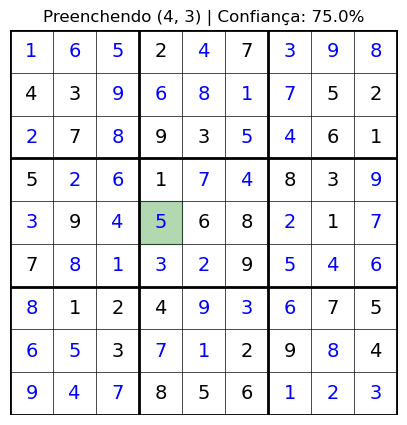

Passo 48: Colocado 5 na posição (5,4)
Sudoku finalizado!
Jogo 743
Células corretas: 81/81


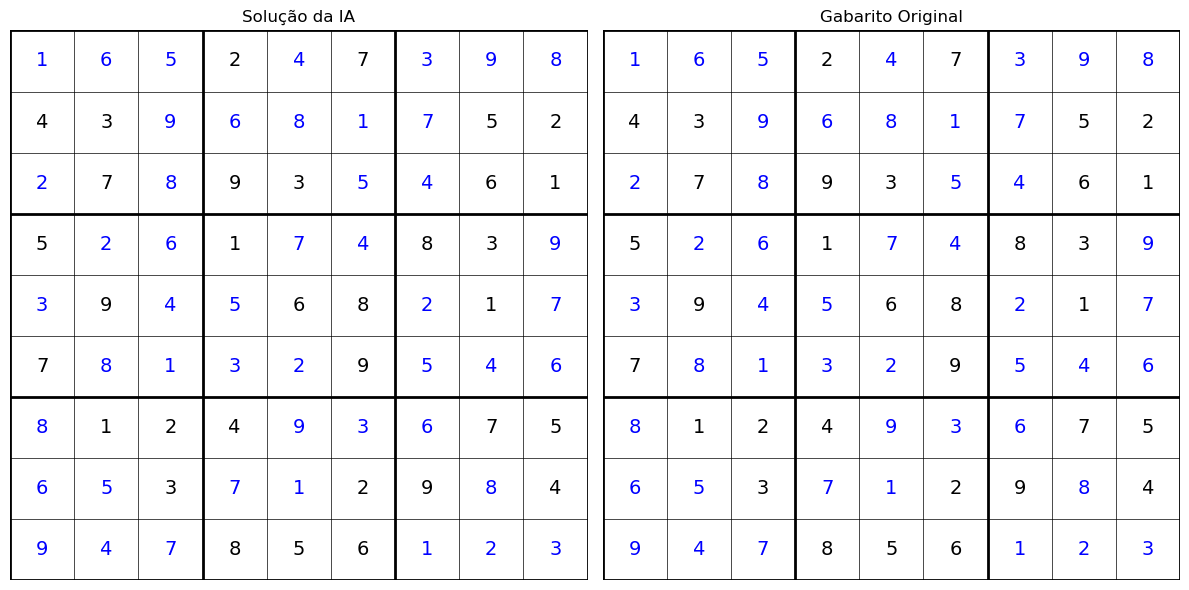

In [12]:
idx_test = np.random.randint(n_sample)
quiz_input = X_test_set[idx_test]
target_output = y_test_set[idx_test]

quiz_solved = solve_sudoku_visual(sudoku_rfc, quiz_input, sleep_time=0.1)
print(f"Jogo {idx_test+1}")

accuracy = np.sum(quiz_solved == target_output)
print(f"Células corretas: {accuracy}/{81}")

compare_results(quiz_solved, target_output, quiz_input)